In [1]:
import warnings
warnings.filterwarnings('ignore')

# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/456

Instituto de Computação - Unicamp 2021

Alunos:
* Daniele Montenegro da Silva Barros
* Rodrigo Dantas da Silva
* Thiago Bruschi Martins

In [2]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [3]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [4]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [5]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [6]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [7]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

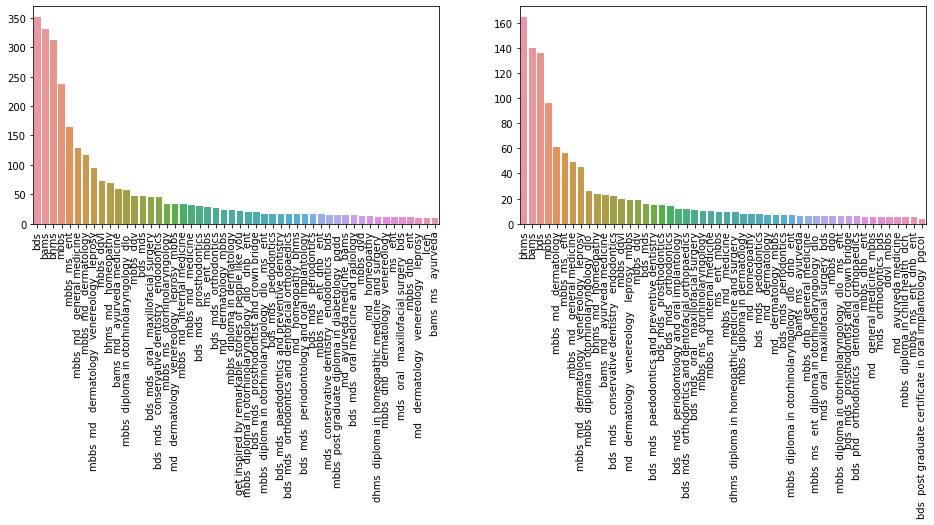

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

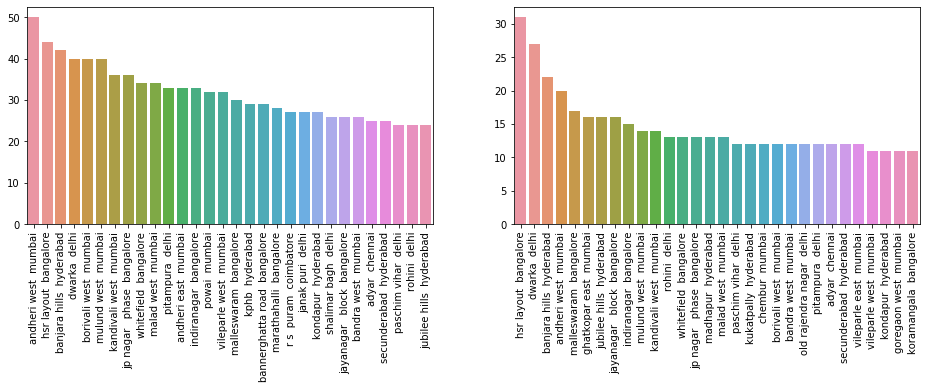

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

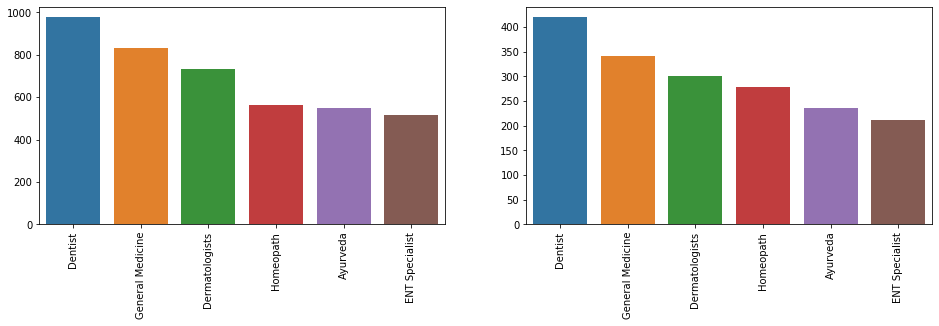

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [12]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [13]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [14]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [15]:
np.random.seed(1082141)
sns.set()

Importando as bibliotecas

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Criando os svm regressores sem a utilização do Grid Seach

In [17]:
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_linear = SVR(kernel='linear', C=0.01, epsilon=0.5)
svr_poly = SVR(kernel='poly', C=1.0, epsilon=1.5)

Treinando os SVR sem o auxílio do Cross Validation Score

In [18]:
svr_rbf.fit(train_e, ye_train)
pred_svr_rbf = svr_rbf.predict(test_e)
print("MSE", mean_squared_error(ye_test, pred_svr_rbf))
print("MAE", mean_absolute_error(ye_test, pred_svr_rbf))

MSE 0.8038962243450666
MAE 0.6768605607013668


In [19]:
svr_linear.fit(train_e, ye_train)
pred_svr_linear = svr_linear.predict(test_e)
print("MSE ", mean_squared_error(ye_test, pred_svr_linear))
print("MAE", mean_absolute_error(ye_test, pred_svr_linear))

MSE  0.8366412166421499
MAE 0.7193223775087725


In [20]:
svr_poly.fit(train_e, ye_train)
pred_svr_poly = svr_poly.predict(test_e)
print("MSE ", mean_squared_error(ye_test, pred_svr_poly))
print("MAE ", mean_absolute_error(ye_test, pred_svr_poly))

MSE  1.0831154656260042
MAE  0.893522801967601


Utilizando o cross_val_score

In [21]:
scores_rbf = cross_val_score(svr_rbf, train_e, ye_train, cv=10, scoring='neg_mean_squared_error', verbose=1)
scores_linear = cross_val_score(svr_linear, train_e, ye_train, cv=10, scoring='neg_mean_squared_error', verbose=1)
scores_poly = cross_val_score(svr_poly, train_e, ye_train, cv=10, scoring='neg_mean_squared_error', verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [22]:
print(f'Score do SVM RBF: {scores_rbf.mean()}')
print(f'Score do SVM Linear:{scores_linear.mean()}')
print(f'Score do SVM Polinomial: {scores_poly.mean()}')

Score do SVM RBF: -0.8320597702019465
Score do SVM Linear:-0.8747896062069543
Score do SVM Polinomial: -1.0775100751127242


#### Criando um grid para os hiperparâmetros

In [23]:
param_grid_svr = {'kernel':('linear', 'rbf', 'poly', "sigmoid"),
              'C': [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],
              'epsilon': [0.001,0.1,0.2,0.3,0.5,1.0,1.5]}

In [24]:
svr_grid = SVR()

In [25]:
grid_svr = GridSearchCV(svr_grid, param_grid=param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)

In [26]:
print(grid_svr.score)

<bound method BaseSearchCV.score of GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'epsilon': [0.001, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             scoring='neg_mean_squared_error', verbose=2)>


In [27]:
grid_svr.fit(train_e, ye_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  1.1min finished


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'epsilon': [0.001, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             scoring='neg_mean_squared_error', verbose=2)

Treinando o melhor modelo

In [28]:
svr = SVR(kernel=grid_svr.best_estimator_.kernel, C=grid_svr.best_estimator_.C, epsilon=grid_svr.best_estimator_.epsilon)

In [29]:
svr.fit(train_e, ye_train)

SVR(epsilon=0.5)

In [30]:
prediction = svr.predict(test_e)
print("MSE: ", mean_squared_error(ye_test, prediction))

MSE:  0.7924806327830223


**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

estimators = [
    (LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False]}),
    (RandomForestRegressor(), {'n_estimators': [10, 30, 50], 'max_depth': [3, 5, 10, 25, 50], 'min_samples_split': [2, 5, 10, 15, 30]})
]

result = []

In [32]:
for models, params in estimators:
  score = cross_validate(GridSearchCV(models, params, cv=3), train_e, ye_train,
                          cv=5, verbose=2, n_jobs=-1,
                          scoring='neg_mean_squared_error')
  result.append(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [33]:
pd.DataFrame({type(models).__name__: pd.DataFrame(r).mean()
              for (models, params), r in zip(estimators, result)}).T

,fit_time,score_time,test_score
LinearRegression,0.356456,0.000356,-0.855905
RandomForestRegressor,59.759386,0.006940,-0.831568


## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [34]:
x, y = datasets.load_digits(return_X_y=True)

x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train_d.shape[0],
      'amostras em teste: %i' % x_test_d.shape[0],
      'número de características: %i' % x_train_d.shape[1],
      'número de classes: %i' % (np.max(y_train_d) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



Optamos por separar o conjunto de treino em conjunto de validação e treino. Deixando 70% para treino e 30% da validação, isso em relação aos dados que foram alocado inicialmente para treino. O conjunto de teste permace intacto. No entanto, para determinamos que trata-se do cojunto de dados dos digitos, inserimos um "_d_", assim: nome das variáveis sofreram essa alteração. 

In [35]:
#determinado a validação cruzada em relação ao conjunto de treino
# 70% para treino e os 30%  para validação
x_train_d, x_val_d, y_train_d, y_val = train_test_split(x_train_d, y_train_d, test_size=0.3,)
print('Dados para o Treino', x_train_d.shape)
print('Dados para a Validação:', x_val_d.shape)

Dados para o Treino (628, 64)
Dados para a Validação: (270, 64)


In [36]:
x

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [37]:
y

array([0, 1, 2, ..., 8, 9, 8])

### 256 primeiras amostras no conjunto de treinamento

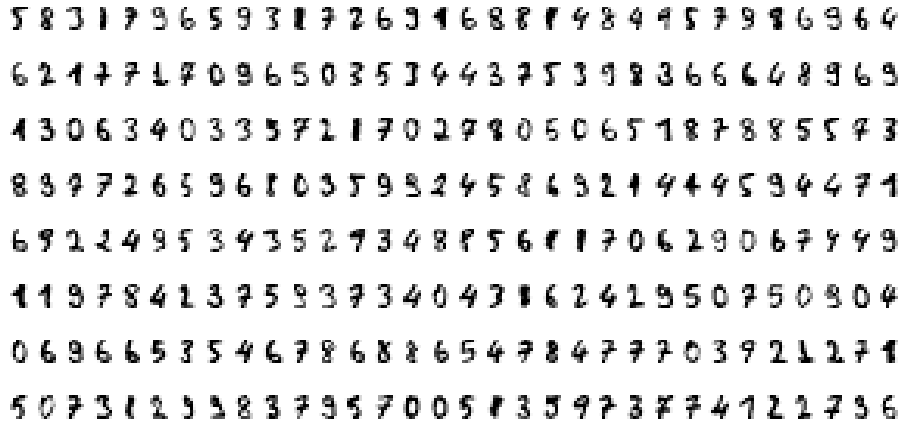

In [38]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train_d[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

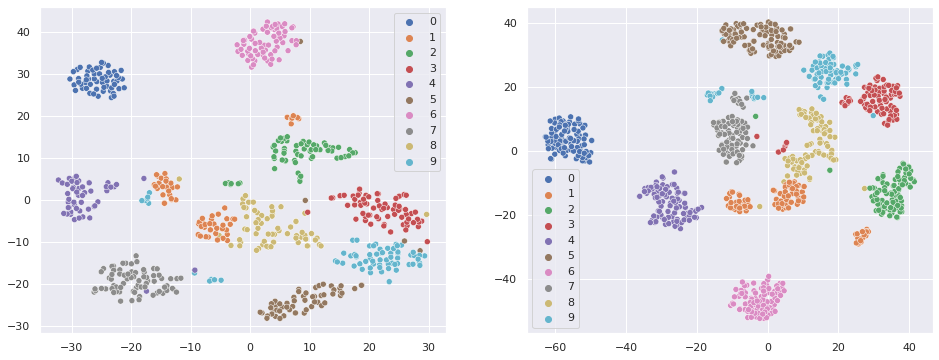

In [39]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train_d)
w_test = encoder2D.fit_transform(x_test_d)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train_d), (w_test, y_test_d))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

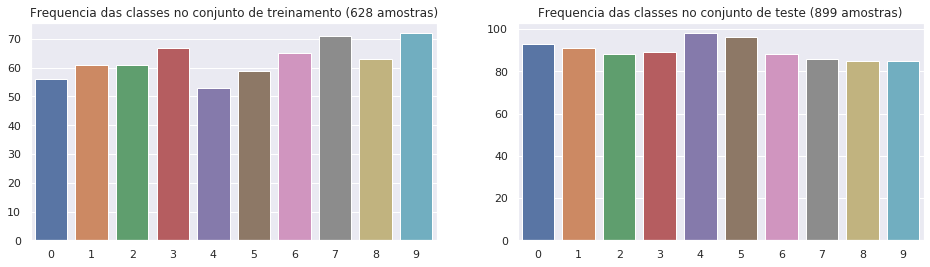

In [40]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train_d))
labels, counts = np.unique(y_train_d, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test_d))
labels, counts = np.unique(y_test_d, return_counts=True)
sns.barplot(labels, counts);

### Definindo funções úteis para o cálculo das métricas de avaliação dos modelos

In [41]:
from sklearn.metrics import auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [42]:
#função para o plot da matriz de confusão
def plot_matriz_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJ"], columns = [i for i in "ABCDEFGHIJ"])
    plt.figure(figsize = (8,8))
    sns.heatmap(df_cm, annot=True,cmap="OrRd")

In [43]:
#função auxiliar para o calculo da acurácia médica
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

Definindo as bibliotecas

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

**Objetivo**: Melhor valor do parâmetro C; intervalo de busca; grid search com validação cruzada em 10 folds.

In [45]:
C_valores_linear = np.logspace(-2, 10, 8)
gamma_valores_linear = np.logspace(-2, 10, 8)

param_grid_linear = {'C': C_valores_linear,
              'gamma': gamma_valores_linear,
              'kernel': ['linear']}

In [46]:
grid_linear = GridSearchCV(SVC(), param_grid=param_grid_linear, cv=10, refit = True, verbose = 3)

In [47]:
grid_linear.fit(x_train_d, y_train_d)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.937, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.937, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.01, gamma=0.01, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ... C=0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.01, gamma=0.517947467923121, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=0.517947467923121, kernel=linear ..................
[CV]  C=0.01, gamma=0.517947467923121, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=0.517947467923121, kernel=linear ..................
[CV]  C=0.01, gamma=0.517947467923121, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.01, gamma=0.517947467923121, kernel=linear ..................
[CV]  C=0.01, gamma=0.517947467923121, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.01, gamma=26.826957952797247, kernel=linear .................
[CV]  C=0.01, gamma=26.826957952797247, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.01, gamma=26.826957952797247, kernel=linear .................
[CV]  C=0.01, gamma=26.826957952797247, kernel=linear, score=0.937, total=   0.0s
[CV] C=0.01, gamma=26.826957952797247, kernel=linear .................
[CV]  C=0.01, gamma=26.826957952797247, kernel=linear, score=0.937, total=   0.0s
[CV]

[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.01, gamma=10000000000.0, kernel=linear ......................
[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=10000000000.0, kernel=linear ......................
[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=10000000000.0, kernel=linear ......................
[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.01, gamma=10000000000.0, kernel=linear ......................
[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.01, gamma=10000000000.0, kernel=linear ......................
[CV]  C=0.01, gamma=10000000000.0, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.517947467923121, gamma=0.01, kernel=linear ..................
[CV]  C=0.517947467923121, gamma=0.01, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.517947467923121, gamma

[CV]  C=0.517947467923121, gamma=3727593.720314938, kernel=linear, score=0.984, total=   0.0s
[CV] C=0.517947467923121, gamma=3727593.720314938, kernel=linear .....
[CV]  C=0.517947467923121, gamma=3727593.720314938, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.517947467923121, gamma=3727593.720314938, kernel=linear .....
[CV]  C=0.517947467923121, gamma=3727593.720314938, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.517947467923121, gamma=193069772.88832456, kernel=linear ....
[CV]  C=0.517947467923121, gamma=193069772.88832456, kernel=linear, score=0.968, total=   0.0s
[CV] C=0.517947467923121, gamma=193069772.88832456, kernel=linear ....
[CV]  C=0.517947467923121, gamma=193069772.88832456, kernel=linear, score=0.937, total=   0.0s
[CV] C=0.517947467923121, gamma=193069772.88832456, kernel=linear ....
[CV]  C=0.517947467923121, gamma=193069772.88832456, kernel=linear, score=0.937, total=   0.0s
[CV] C=0.517947467923121, gamma=193069772.88832456, kernel=linear ....
[CV]  C

[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.968, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.937, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.937, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.984, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.968, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]  C=26.826957952797247, gamma=71968.56730011514, kernel=linear, score=0.984, total=   0.0s
[CV] C=26.826957952797247, gamma=71968.56730011514, kernel=linear ....
[CV]

[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.984, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ...
[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.968, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ...
[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.984, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ...
[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.984, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ...
[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.984, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ...
[CV]  C=1389.4954943731361, gamma=26.826957952797247, kernel=linear, score=0.968, total=   0.0s
[CV] C=1389.4954943731361, gamma=26.826957952797247, kernel=linear ..

[CV]  C=71968.56730011514, gamma=0.01, kernel=linear, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=0.01, kernel=linear ..................
[CV]  C=71968.56730011514, gamma=0.01, kernel=linear, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=0.01, kernel=linear ..................
[CV]  C=71968.56730011514, gamma=0.01, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=0.01, kernel=linear ..................
[CV]  C=71968.56730011514, gamma=0.01, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=0.517947467923121, kernel=linear .....
[CV]  C=71968.56730011514, gamma=0.517947467923121, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=0.517947467923121, kernel=linear .....
[CV]  C=71968.56730011514, gamma=0.517947467923121, kernel=linear, score=0.937, total=   0.0s
[CV] C=71968.56730011514, gamma=0.517947467923121, kernel=linear .....
[CV]  C=71968.56730011514, gamma=0.517947467923121, kernel=lin

[CV]  C=71968.56730011514, gamma=193069772.88832456, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, gamma=10000000000.0, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, gamma=10000000000.0, kernel=linear, score=0.937, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, gamma=10000000000.0, kernel=linear, score=0.937, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, gamma=10000000000.0, kernel=linear, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=10000000000.0, kernel=linear .........
[CV]  C=71968.56730011514, ga

[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.937, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.984, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.968, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.984, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.984, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=3727593.720314938, gamma=3727593.720314938, kernel=linear, score=0.984, total=   0.0s
[CV] C=3727593.720314938, gamma=3727593.720314938, kernel=linear .....
[CV]  C=37

[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.968, total=   0.0s
[CV] C=193069772.88832456, gamma=1389.4954943731361, kernel=linear ...
[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=1389.4954943731361, kernel=linear ...
[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=1389.4954943731361, kernel=linear ...
[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=1389.4954943731361, kernel=linear ...
[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.968, total=   0.0s
[CV] C=193069772.88832456, gamma=1389.4954943731361, kernel=linear ...
[CV]  C=193069772.88832456, gamma=1389.4954943731361, kernel=linear, score=0.968, total=   0.0s
[CV] C=193069772.88832456, gamma=71968.56730011514, kernel=linear ...

[CV]  C=10000000000.0, gamma=0.517947467923121, kernel=linear, score=0.984, total=   0.0s
[CV] C=10000000000.0, gamma=0.517947467923121, kernel=linear .........
[CV]  C=10000000000.0, gamma=0.517947467923121, kernel=linear, score=0.984, total=   0.0s
[CV] C=10000000000.0, gamma=0.517947467923121, kernel=linear .........
[CV]  C=10000000000.0, gamma=0.517947467923121, kernel=linear, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=0.517947467923121, kernel=linear .........
[CV]  C=10000000000.0, gamma=0.517947467923121, kernel=linear, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=26.826957952797247, kernel=linear ........
[CV]  C=10000000000.0, gamma=26.826957952797247, kernel=linear, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=26.826957952797247, kernel=linear ........
[CV]  C=10000000000.0, gamma=26.826957952797247, kernel=linear, score=0.937, total=   0.0s
[CV] C=10000000000.0, gamma=26.826957952797247, kernel=linear ........
[CV]  C=10000000000.0, gamma=26.

[CV]  C=10000000000.0, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=10000000000.0, gamma=10000000000.0, kernel=linear .............
[CV]  C=10000000000.0, gamma=10000000000.0, kernel=linear, score=0.984, total=   0.0s
[CV] C=10000000000.0, gamma=10000000000.0, kernel=linear .............
[CV]  C=10000000000.0, gamma=10000000000.0, kernel=linear, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=10000000000.0, kernel=linear .............
[CV]  C=10000000000.0, gamma=10000000000.0, kernel=linear, score=0.968, total=   0.0s


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:    6.5s finished


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10]),
                         'gamma': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10]),
                         'kernel': ['linear']},
             verbose=3)

In [48]:
print(grid_linear.best_score_)
print(grid_linear.best_params_)
print(grid_linear.best_estimator_)

0.9681515616999488
{'C': 0.517947467923121, 'gamma': 0.01, 'kernel': 'linear'}
SVC(C=0.517947467923121, gamma=0.01, kernel='linear')


Usando o grid predictions: testando com o conjunto de validação

In [49]:
grid_predictions_l = grid_linear.predict(x_val_d)

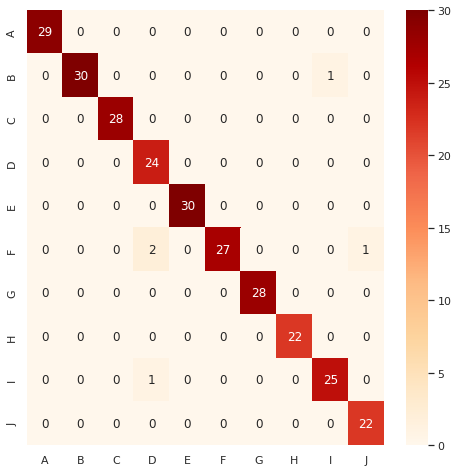

In [50]:
plot_matriz_confusion(grid_predictions_l, y_val)

**Objetivo**: Treinar uma SVM com Kernel linear com o melhor parâmetro obtido atráves do Grid

In [51]:
svm_linear = SVC(kernel = 'linear', C=grid_linear.best_estimator_.C, gamma=grid_linear.best_estimator_.gamma)

In [52]:
svm_linear.fit(x_train_d, y_train_d)

SVC(C=0.517947467923121, gamma=0.01, kernel='linear')

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

In [53]:
y_pred_linear = svm_linear.predict(x_test_d)

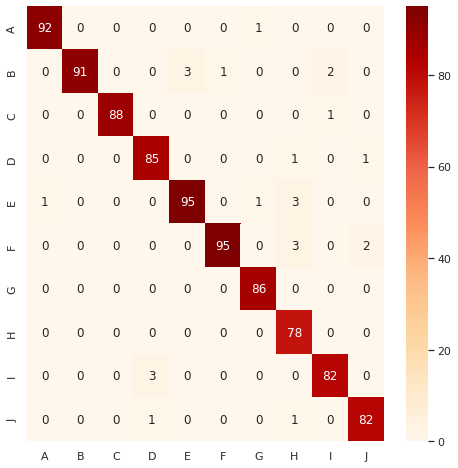

In [54]:
plot_matriz_confusion(y_pred_linear, y_test_d)

In [55]:
print(classification_report(y_test_d, y_pred_linear))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.94      1.00      0.97        91
           2       0.99      1.00      0.99        88
           3       0.98      0.96      0.97        89
           4       0.95      0.97      0.96        98
           5       0.95      0.99      0.97        96
           6       1.00      0.98      0.99        88
           7       1.00      0.91      0.95        86
           8       0.96      0.96      0.96        85
           9       0.98      0.96      0.97        85

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



In [56]:
results_linear = cross_val_score(svm_linear, x_train_d, y_train_d, cv = 5, scoring = 'accuracy')
   
intervalo(results_linear)

Acurácia média: 96.66%
Intervalo de acurácia: [95.11% ~ 98.20%]


### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

Variando o valor de C e Gamma usando o GridSearchCV

In [57]:
C_valores_rbf = np.logspace(-2, 10, 8)
gamma_valores_rbf = np.logspace(-9, 3, 8)

param_grid_rbf = {'C': C_valores_rbf,
              'gamma': gamma_valores_rbf,
              'kernel': ['rbf']}

In [58]:
grid_rbf = GridSearchCV(SVC(), param_grid=param_grid_rbf, cv=10, refit = True, verbose = 3)

In [59]:
grid_rbf.fit(x_train_d, y_train_d)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.238, total=   0.0s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.222, total=   0.0s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.113, total=   0.1s
[CV] C=0.01, gamma=1e-09, kernel=rbf .................................
[CV] ..... C=0.01, gamma=1e-09, kernel=rbf, score=0.113, total=   0.0s
[CV] C=0.01, gamma=5.1794746792312124e-08, kernel=rbf ................
[CV]  

[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.127, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.127, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=19.306977288832456, kernel=rbf ....................
[CV]  C=0.01, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=0.01, gamma=19

[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.921, total=   0.0s
[CV] C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf ....
[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.984, total=   0.0s
[CV] C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf ....
[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.952, total=   0.0s
[CV] C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf ....
[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.968, total=   0.0s
[CV] C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf ....
[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.935, total=   0.0s
[CV] C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf ....
[CV]  C=0.517947467923121, gamma=0.0001389495494373136, kernel=rbf, score=0.919, total=   0.0s
[CV] C=0.517947467923121, gamma=0.007196856730011514, kernel=rbf .....
[CV]

[CV]  C=26.826957952797247, gamma=1e-09, kernel=rbf, score=0.113, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf, score=0.238, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf, score=0.222, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=5.1794746792312124e-08, kernel=rbf ..
[CV]  C=2

[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.127, total=   0.0s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.0s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.826957952797247, gamma=19.306977288832456, kernel=rbf, score=0.111, total=   0.1s
[CV] C=26.826957952797247, gamma=19.306977288832456, kernel=rbf ......
[CV]  C=26.82695

[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.857, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.810, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.762, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.794, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.841, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]  C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf, score=0.857, total=   0.0s
[CV] C=1389.4954943731361, gamma=0.007196856730011514, kernel=rbf ....
[CV]

[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.937, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ...
[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.937, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ...
[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ...
[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.968, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ...
[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ...
[CV]  C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=71968.56730011514, gamma=2.6826957952797274e-06, kernel=rbf ..

[CV]  C=71968.56730011514, gamma=1000.0, kernel=rbf, score=0.111, total=   0.0s
[CV] C=71968.56730011514, gamma=1000.0, kernel=rbf ...................
[CV]  C=71968.56730011514, gamma=1000.0, kernel=rbf, score=0.111, total=   0.0s
[CV] C=71968.56730011514, gamma=1000.0, kernel=rbf ...................
[CV]  C=71968.56730011514, gamma=1000.0, kernel=rbf, score=0.111, total=   0.0s
[CV] C=71968.56730011514, gamma=1000.0, kernel=rbf ...................
[CV]  C=71968.56730011514, gamma=1000.0, kernel=rbf, score=0.113, total=   0.0s
[CV] C=71968.56730011514, gamma=1000.0, kernel=rbf ...................
[CV]  C=71968.56730011514, gamma=1000.0, kernel=rbf, score=0.113, total=   0.0s
[CV] C=3727593.720314938, gamma=1e-09, kernel=rbf ....................
[CV]  C=3727593.720314938, gamma=1e-09, kernel=rbf, score=0.952, total=   0.0s
[CV] C=3727593.720314938, gamma=1e-09, kernel=rbf ....................
[CV]  C=3727593.720314938, gamma=1e-09, kernel=rbf, score=0.937, total=   0.0s
[CV] C=3727593.7

[CV]  C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf, score=0.841, total=   0.1s
[CV] C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf .....
[CV]  C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf, score=0.857, total=   0.1s
[CV] C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf .....
[CV]  C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf, score=0.839, total=   0.0s
[CV] C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf .....
[CV]  C=3727593.720314938, gamma=0.007196856730011514, kernel=rbf, score=0.887, total=   0.0s
[CV] C=3727593.720314938, gamma=0.3727593720314938, kernel=rbf .......
[CV]  C=3727593.720314938, gamma=0.3727593720314938, kernel=rbf, score=0.111, total=   0.1s
[CV] C=3727593.720314938, gamma=0.3727593720314938, kernel=rbf .......
[CV]  C=3727593.720314938, gamma=0.3727593720314938, kernel=rbf, score=0.127, total=   0.1s
[CV] C=3727593.720314938, gamma=0.3727593720314938, kernel=rbf .......
[CV]  C=372759

[CV]  C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf ..
[CV]  C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf ..
[CV]  C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf ..
[CV]  C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf, score=0.968, total=   0.0s
[CV] C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf ..
[CV]  C=193069772.88832456, gamma=2.6826957952797274e-06, kernel=rbf, score=0.968, total=   0.0s
[CV] C=193069772.88832456, gamma=0.0001389495494373136, kernel=rbf ...
[CV]  C=193069772.88832456, gamma=0.0001389495494373136, kernel=rbf, score=0.984, total=   0.0s
[CV] C=193069772.88832456, gamma=0.0001389495494373136, kernel=r

[CV]  C=193069772.88832456, gamma=1000.0, kernel=rbf, score=0.113, total=   0.0s
[CV] C=193069772.88832456, gamma=1000.0, kernel=rbf ..................
[CV]  C=193069772.88832456, gamma=1000.0, kernel=rbf, score=0.113, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, kernel=rbf ........................
[CV]  C=10000000000.0, gamma=1e-09, kernel=rbf, score=0.952, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, kernel=rbf ........................
[CV]  C=10000000000.0, gamma=1e-09, kernel=rbf, score=0.937, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, kernel=rbf ........................
[CV]  C=10000000000.0, gamma=1e-09, kernel=rbf, score=0.937, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, kernel=rbf ........................
[CV]  C=10000000000.0, gamma=1e-09, kernel=rbf, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, kernel=rbf ........................
[CV]  C=10000000000.0, gamma=1e-09, kernel=rbf, score=0.968, total=   0.0s
[CV] C=10000000000.0, gamma=1e-09, ke

[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.111, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.127, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.127, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.111, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.111, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.3727593720314938, kernel=rbf, score=0.111, total=   0.1s
[CV] C=10000000000.0, gamma=0.3727593720314938, kernel=rbf ...........
[CV]  C=10000000000.0, gamma=0.372759372031493

[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:   25.7s finished


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10]),
                         'gamma': array([1.00000000e-09, 5.17947468e-08, 2.68269580e-06, 1.38949549e-04,
       7.19685673e-03, 3.72759372e-01, 1.93069773e+01, 1.00000000e+03]),
                         'kernel': ['rbf']},
             verbose=3)

In [60]:
print(grid_rbf.best_score_)
print(grid_rbf.best_params_)
print(grid_rbf.best_estimator_)

0.9745007680491551
{'C': 26.826957952797247, 'gamma': 0.0001389495494373136, 'kernel': 'rbf'}
SVC(C=26.826957952797247, gamma=0.0001389495494373136)


In [61]:
grid_predictions = grid_rbf.predict(x_val_d)

In [62]:
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        28
           3       1.00      0.89      0.94        27
           4       1.00      1.00      1.00        30
           5       0.90      1.00      0.95        27
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        22
           8       0.96      0.96      0.96        26
           9       1.00      0.96      0.98        23

    accuracy                           0.98       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.98      0.98      0.98       270



**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [63]:
from sklearn.model_selection import RandomizedSearchCV

In [64]:
svm_rbf = SVC()
rand_rbf = RandomizedSearchCV(svm_rbf, param_grid_rbf, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand_rbf.fit(x_train_d, y_train_d)

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10]),
                                        'gamma': array([1.00000000e-09, 5.17947468e-08, 2.68269580e-06, 1.38949549e-04,
       7.19685673e-03, 3.72759372e-01, 1.93069773e+01, 1.00000000e+03]),
                                        'kernel': ['rbf']},
                   random_state=5, scoring='accuracy')

In [65]:
print(rand_rbf.best_score_)
print(rand_rbf.best_params_)

0.9649769585253456
{'kernel': 'rbf', 'gamma': 1e-09, 'C': 10000000000.0}


In [66]:
rand_rbf.fit(x_train_d, y_train_d)

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10]),
                                        'gamma': array([1.00000000e-09, 5.17947468e-08, 2.68269580e-06, 1.38949549e-04,
       7.19685673e-03, 3.72759372e-01, 1.93069773e+01, 1.00000000e+03]),
                                        'kernel': ['rbf']},
                   random_state=5, scoring='accuracy')

Testando o rand com o conjunto de validação

In [67]:
rand_pred_rbf = rand_rbf.predict(x_val_d)

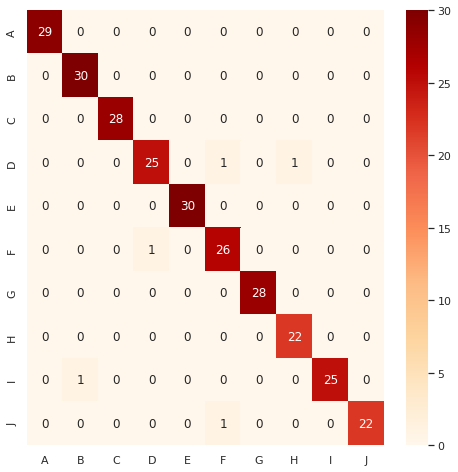

In [68]:
plot_matriz_confusion(y_val, rand_pred_rbf)

Comparando o Grid Search com o Randomize

In [69]:
print(grid_rbf.cv_results_['mean_test_score'].mean())
print(rand_rbf.cv_results_['mean_test_score'].mean())

0.4803619431643624
0.3434869431643625


O grid search obeteve o melhor resultado. 

### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

In [70]:
svm_rbf = SVC(kernel = 'rbf', C=grid_rbf.best_estimator_.C, gamma=grid_rbf.best_estimator_.gamma)

In [71]:
svm_rbf.fit(x_train_d, y_train_d)

SVC(C=26.826957952797247, gamma=0.0001389495494373136)

In [72]:
y_pred_rbf = svm_rbf.predict(x_test_d)

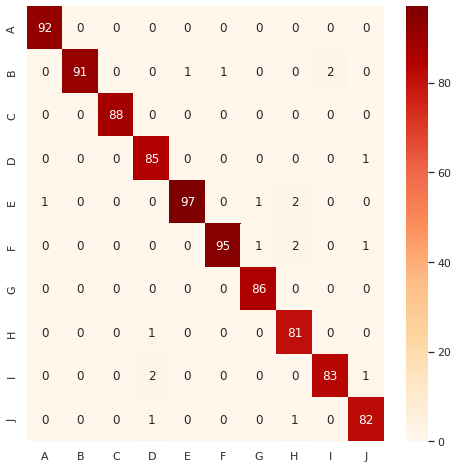

In [73]:
plot_matriz_confusion(y_pred_rbf, y_test_d)

In [74]:
print(classification_report(y_test_d, y_pred_rbf))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        93
           1       0.96      1.00      0.98        91
           2       1.00      1.00      1.00        88
           3       0.99      0.96      0.97        89
           4       0.96      0.99      0.97        98
           5       0.96      0.99      0.97        96
           6       1.00      0.98      0.99        88
           7       0.99      0.94      0.96        86
           8       0.97      0.98      0.97        85
           9       0.98      0.96      0.97        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899



In [75]:
results_rbf = cross_val_score(svm_rbf, x_train_d, y_train_d, cv = 5, scoring = 'accuracy')
   
intervalo(results_rbf)

Acurácia média: 97.45%
Intervalo de acurácia: [94.72% ~ 100.18%]
